# Corona in Hamburg

In [1]:
import datetime
import os
import re
import urllib.parse

import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [2]:
CORONA_DATA_URL = "https://www.hamburg.de/corona-zahlen/"
MONTHS = ["Januar", "Februar", "März", "April", "Mai", "Juni",
          "Juli", "August", "September", "Oktober", "November", "Dezember"]
BOROUGHS = {
    "Altona": 275264,
    "Bergedorf": 130260,
    "Eimsbüttel": 267051,
    "Hamburg Mitte": 301543,
    "Hamburg Nord": 314593,
    "Harburg": 169426,
    "Wandsbek": 441012,
    "Hamburg": 1899160,
}

In [3]:
def parse_data(src):
    soup = bs4.BeautifulSoup(src)
    
    historic_case_data_header = soup.find("h2", text="Inzidenz zum Download")
    if historic_case_data_header:
        df = pd.read_excel(
            urllib.parse.urljoin(
                CORONA_DATA_URL,
                historic_case_data_header.parent.find_next("div").a["href"]
            ),
            index_col=1,
            skiprows=[0],
            parse_dates=True
        )
        
        df = df.drop(
            set(df.columns) - {"Datum", "Gesamthaft gemeldete SARS-CoV-2 Infektionen"},
            axis="columns"
        ).rename(columns={
            "Datum": "date",
            "Gesamthaft gemeldete SARS-CoV-2 Infektionen": "cases"
        }).dropna().diff().dropna().astype(int)

        daily_cases = pd.read_csv("corona-hamburg-daily.csv", index_col=0, parse_dates=True)
        daily_cases.update(df)
        daily_cases.astype(int).to_csv("corona-hamburg-daily.csv")

    header = soup.find("h2", text="Neue Fälle: Sieben Tage Chart")
    if not header:
        header = soup.find("h2", text="Neue Fälle: Sieben Tage Inzidenz")

    if header:
        values = [el.text.strip() for el in soup.find_all(attrs={"class": "value_show"})]
        par = soup.find(lambda el: el.name == "p" and el.text.strip().startswith("Bei der Inzidenz"))
        if values and par:
            date = datetime.datetime.strptime(par.find_all("strong")[1].text[1:-1], "%d.%m.%Y").date()
            dates = reversed([(date - datetime.timedelta(days=d)).isoformat() for d in range(7)])

            note = soup.find("strong", text=re.compile(r"Hinweis"))
            if note:
                print(date.isoformat(), note.parent.text.strip())
            
            with open("corona-hamburg-daily.csv", "r") as f:
                lines = [line.strip() for line in f]

            with open("corona-hamburg-daily.csv", "a") as f:
                for line in [f"{d},{val}" for d, val in zip(dates, values)]:
                    if line not in lines:
                        f.write(f"{line}\n")

    header = soup.find("h3", text="Entwicklung der Zahl der positiv auf COVID-19 getesteten Personen nach Bezirken")
    if header:
        table = header.parent.find("table")
        timestamp = table.parent.parent.find_all("p")[-1].text.replace("Stand:", "")
        timestamp = re.sub(r"[.,]+", " ", timestamp).split()
        timestamp = f"{timestamp[2]}-{MONTHS.index(timestamp[1])+1:0>2}-{int(timestamp[0]):0>2}"
        total_cases = [timestamp,"total"]
        active_cases = [timestamp,"active"]
        for row in table.find_all("tr"):
            borough = row.find(attrs={"data-label": "Bezirk"})
            if not borough:
                continue
            cases = row.find(attrs={"data-label": "Fallzahlen"})
            if cases:
                total_cases.append(cases.text.strip())
            cases = (
                row.find(attrs={"data-label": "Fälle vergangene 14 Tage"})
                or row.find(attrs={"data-label": "Fälle letzte 14 Tage"})
            )
            if cases:
                active_cases.append(cases.text.strip())

        with open("corona-hamburg.csv") as f:
            lines = [line.strip() for line in f]
        
        with open("corona-hamburg.csv", "a") as f:
            total_cases_line = ",".join(total_cases)
            if total_cases_line not in lines and len(total_cases) > 2:
                f.write(f"{total_cases_line}\n")

            active_cases_line = ",".join(active_cases)
            if active_cases_line not in lines and len(active_cases) > 2:
                f.write(f"{active_cases_line}\n")

In [4]:
r = requests.get(CORONA_DATA_URL)
if r.ok:
    parse_data(r.text)

In [5]:
daily_cases = pd.read_csv("corona-hamburg-daily.csv", index_col=0, parse_dates=True)
daily_cases_rolling7 = daily_cases.rolling(7).sum().dropna()
daily_cases_rolling14 = daily_cases.rolling(14).sum().dropna()

In [6]:
df = pd.read_csv("corona-hamburg.csv", index_col=0, parse_dates=True)
total_cases = df[df["type"] == "total"].drop(["type"], axis="columns").astype(int)
new_cases = total_cases.diff().dropna().astype(int)

In [7]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

In [8]:
def stackplot(df, title):
    plt.stackplot(df.index, *df.values.T, labels=df.columns)
    plt.legend(loc="upper left")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Cases")
    plt.xticks(rotation=60)
    plt.xlim(xmin=df.index[0])
    plt.grid()

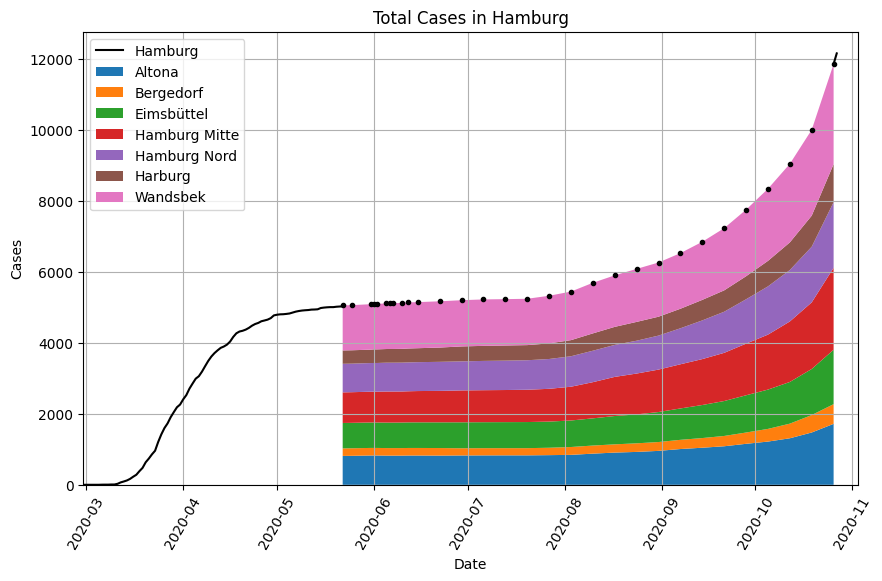

In [9]:
stackplot(total_cases, "Total Cases in Hamburg")
first_total = daily_cases.index.get_loc(total_cases.index[0]) + 1
last_total = total_cases.index.intersection(daily_cases.index)[-1]
total_daily_cases = pd.DataFrame([total_cases.T[last_total].sum()], index=[last_total], columns=["cases"]).append(daily_cases[last_total:].drop(index=[last_total])).cumsum()
plt.plot(total_daily_cases.index, total_daily_cases.values, "black", label="Hamburg")
plt.plot(daily_cases.index[:first_total], daily_cases.cumsum()[:first_total], "black")
plt.plot(total_cases.index, total_cases.sum("columns"), "k.")
plt.legend(loc="upper left")
plt.xlim(xmin=daily_cases.index[0])
plt.show()

In [10]:
total_cases["Hamburg"] = total_cases.sum("columns")
total_cases.tail(10)

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,Hamburg
date,,,,,,,,
2020-08-24,927,242,814,1151,925,530,1493,6082
2020-08-31,956,249,845,1195,958,532,1526,6261
2020-09-07,1008,259,884,1244,1014,550,1567,6526
2020-09-14,1045,272,931,1293,1090,578,1636,6845
2020-09-21,1086,290,984,1357,1158,602,1752,7229
2020-09-28,1155,318,1049,1454,1250,648,1875,7749
2020-10-05,1218,357,1107,1548,1359,718,2031,8338
2020-10-12,1311,412,1174,1704,1449,778,2212,9040
2020-10-19,1474,491,1298,1876,1568,874,2420,10001


In [11]:
total_daily_cases.T

,2020-10-26,2020-10-27
cases,11852,12152


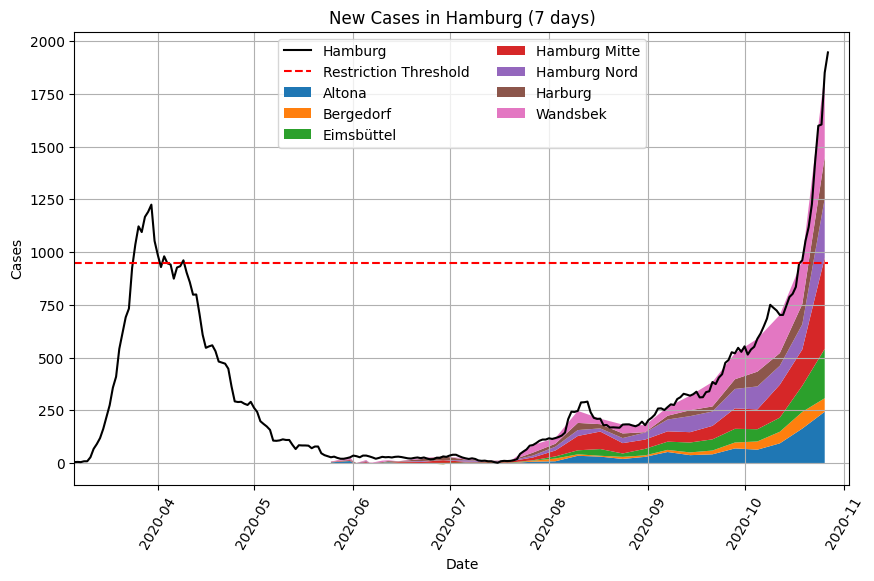

In [12]:
stackplot(new_cases, "New Cases in Hamburg (7 days)")
plt.plot(daily_cases_rolling7.index, daily_cases_rolling7.values, "black", label="Hamburg")
plt.plot([daily_cases_rolling7.index[0], daily_cases_rolling7.index[-1]], [950, 950], "r--", label="Restriction Threshold")
plt.legend(loc="upper center", ncol=2)
plt.xlim(xmin=daily_cases_rolling7.index[0])
plt.show()

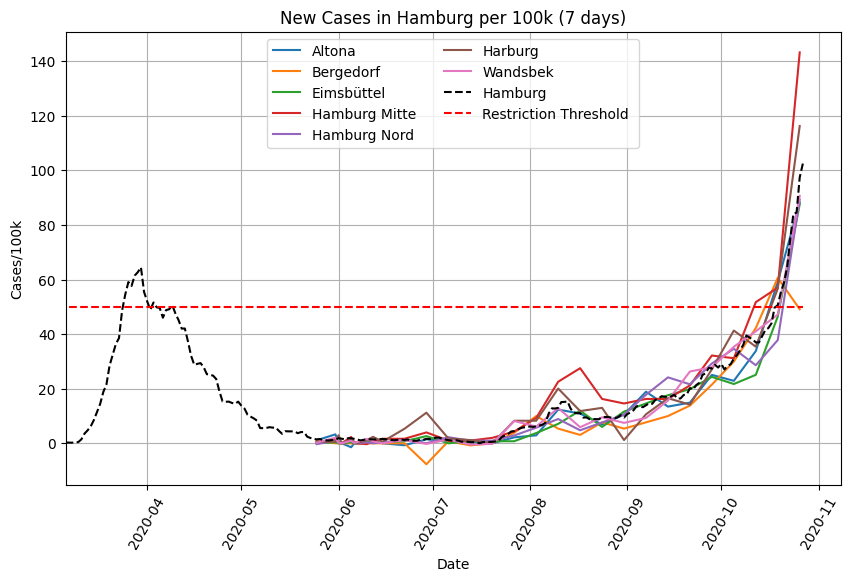

In [13]:
for borough in new_cases.columns:
    plt.plot(new_cases.index, new_cases[borough] / BOROUGHS[borough] * 1e5, label=borough)

plt.plot(daily_cases_rolling7.index, daily_cases_rolling7.values / BOROUGHS["Hamburg"] * 1e5, "k--", label="Hamburg")
plt.plot([daily_cases.index[0], daily_cases_rolling7.index[-1]], [50, 50], "r--", label="Restriction Threshold ")
plt.title("New Cases in Hamburg per 100k (7 days)")
plt.legend(loc="upper center", ncol=2)
plt.xlabel("Date")
plt.ylabel("Cases/100k")
plt.xticks(rotation=60)
plt.xlim(xmin=daily_cases_rolling7.index[0])
plt.grid()
plt.show()

In [14]:
new_cases["Hamburg"] = new_cases.sum("columns")
new_cases.tail(10)

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,Hamburg
date,,,,,,,,
2020-08-24,19,10,16,49,24,22,42,182
2020-08-31,29,7,31,44,33,2,33,179
2020-09-07,52,10,39,49,56,18,41,265
2020-09-14,37,13,47,49,76,28,69,319
2020-09-21,41,18,53,64,68,24,116,384
2020-09-28,69,28,65,97,92,46,123,520
2020-10-05,63,39,58,94,109,70,156,589
2020-10-12,93,55,67,156,90,60,181,702
2020-10-19,163,79,124,172,119,96,208,961


In [15]:
daily_cases_rolling7.tail(7).T

date,2020-10-21,2020-10-22,2020-10-23,2020-10-24,2020-10-25,2020-10-26,2020-10-27
cases,1119.0,1227.0,1427.0,1599.0,1605.0,1851.0,1947.0


In [16]:
(daily_cases_rolling7 / BOROUGHS["Hamburg"] * 1e5).tail(7).round(2).T

date,2020-10-21,2020-10-22,2020-10-23,2020-10-24,2020-10-25,2020-10-26,2020-10-27
cases,58.92,64.61,75.14,84.2,84.51,97.46,102.52


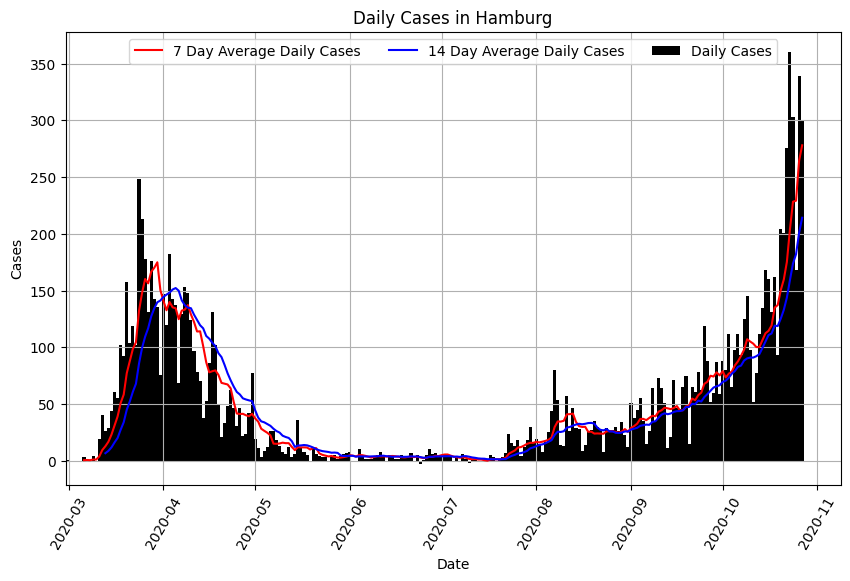

In [17]:
plt.bar(daily_cases.index, daily_cases.values.T[0], width=1, color="black", label="Daily Cases")
plt.plot(daily_cases_rolling7.index, daily_cases_rolling7 / 7, "red", label="7 Day Average Daily Cases")
plt.plot(daily_cases_rolling14.index, daily_cases_rolling14 / 14, "blue", label="14 Day Average Daily Cases")
plt.title("Daily Cases in Hamburg")
plt.legend(loc="upper center", ncol=3)
plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=60)
plt.xlim(xmin=daily_cases.index[0])
plt.grid()
plt.show()

In [18]:
daily_cases.tail(7).T

date,2020-10-21,2020-10-22,2020-10-23,2020-10-24,2020-10-25,2020-10-26,2020-10-27
cases,201,276,360,303,168,339,300
